In [1]:
import pandas as pd
import duckdb

In [71]:
db = "../../data/raw_data.db"

conn = duckdb.connect(db)
df = conn.execute("SELECT * FROM raw_summoner_game_logs where game_start_timestamp >= DATE '2025-04-14';").fetchdf()
print(f"[INFO] Load {len(df)} records: {len(df.summoner_id.unique())} summoners.")
df.sample(1)

[INFO] Load 40397 records: 559 summoners.


,match_id,summoner_id,tier,rank,team_id,end_of_game_result,game_start_timestamp,game_end_timestamp,game_duration,game_mode,...,game_ended_surrender,kda,total_ping_count,primary_perk_style,primary_perk1,primary_perk2,primary_perk3,sub_perk_style,sub_perk1,sub_perk2
31658,KR_7604405620,mGwRN6Z4LR6UZoLQfabMMPz76qtvEBxnM2Qzdj9j_SF2wrnh,DIAMOND,IV,200,True,2025-04-18 05:41:47.047,2025-04-18 06:07:14.796,0 days 00:25:27,CLASSIC,...,True,1.3,18,8100,8112,8126,8140,8000,8014,8009


In [72]:
# 1.1 D-d Retention
from datetime import datetime, timedelta

df['timestamp'] = df['game_start_timestamp'].apply(lambda x: x.date())

today = datetime(2025, 5, 14)
target = today - timedelta(days=30)
target_ids = set(df[df.timestamp == target.date()].summoner_id.unique())

ds = [1, 3, 7, 30]
d_retentions = []
print(f"[INFO] \tTarget Size: {len(target_ids)}")
for d in ds:
    d_af = target + timedelta(days=d)
    d_ids = set(df[df.timestamp == d_af.date()].summoner_id.unique())
    
    d_retention = len(d_ids & target_ids) / len(d_ids) if d_ids else 0
    d_retentions.append(d_retention)
    print(f"[INFO] \t\tD-{d} Retention is {d_retention:.4f}")

[INFO] 	Target Size: 220
[INFO] 		D-1 Retention is 0.7136
[INFO] 		D-3 Retention is 0.6667
[INFO] 		D-7 Retention is 0.6091
[INFO] 		D-30 Retention is 0.6250


,game_mode,timestamp,session_length,session_minutes
0,ARAM,2025-04-14,0 days 01:01:44,61.733333
1,ARAM,2025-04-15,0 days 01:00:59,60.983333
2,ARAM,2025-04-16,0 days 00:43:56,43.933333
3,ARAM,2025-04-17,0 days 00:46:52.500000,46.875000
4,ARAM,2025-04-18,0 days 01:03:39,63.650000
...,...,...,...,...
99,SWIFTPLAY,2025-04-21,0 days 00:22:59,22.983333
100,SWIFTPLAY,2025-04-22,0 days 00:42:08.500000,42.141667
101,SWIFTPLAY,2025-04-30,0 days 00:17:20,17.333333
102,SWIFTPLAY,2025-05-12,0 days 00:09:46,9.766667


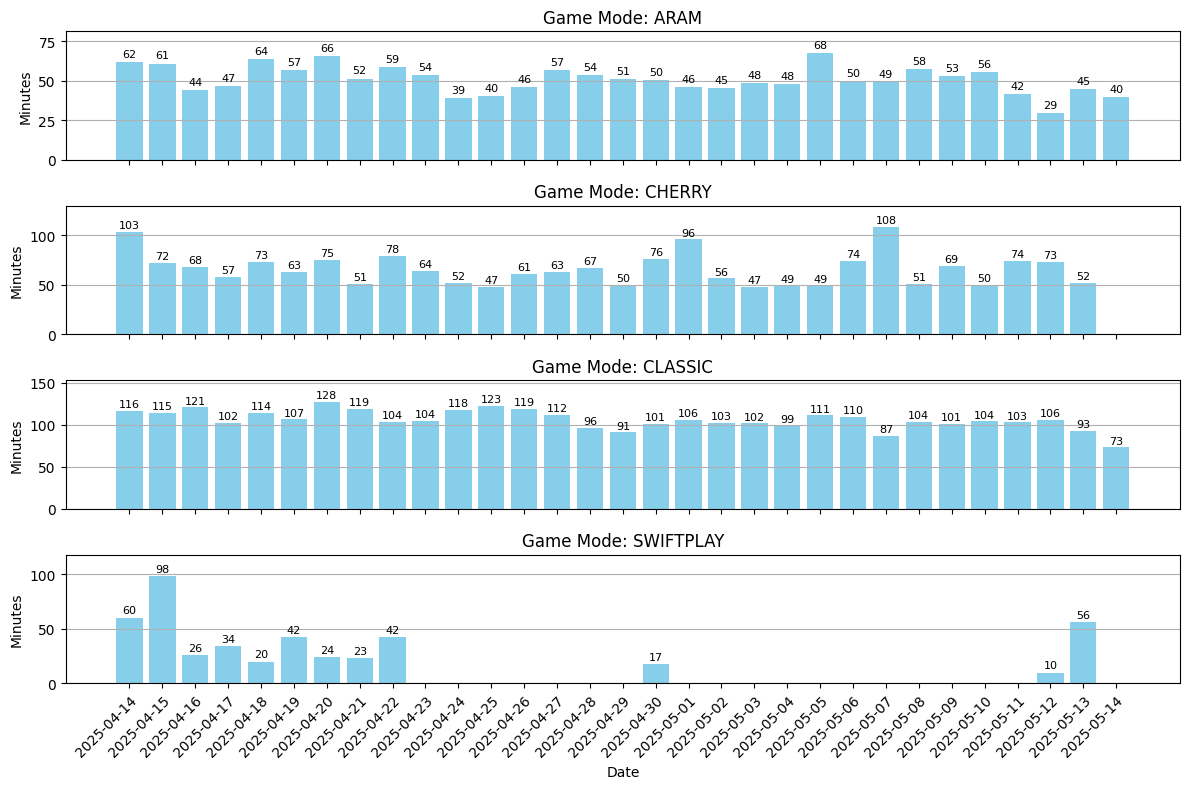

In [176]:
# 1.2 Average Session Length -> 지속시간, 몰입도, 콘텐츠 길이
avg_session_length = df.groupby(["game_mode", "timestamp", "summoner_id"]).game_duration.sum().reset_index(name="session_length")
avg_session_length = avg_session_length.groupby(["game_mode", "timestamp"]).session_length.median().reset_index() # 편차가 큰 편이라 조금 더 robust한 median 사용
avg_session_length["session_minutes"] = avg_session_length["session_length"].dt.total_seconds() / 60
display(avg_session_length)

import matplotlib.pyplot as plt
modes = avg_session_length["game_mode"].unique()
fig, axes = plt.subplots(nrows=len(modes), ncols=1, figsize=(12, 8), sharex=True)

for ax, mode in zip(axes, modes):
    subset = avg_session_length[avg_session_length["game_mode"] == mode]
    bars = ax.bar(subset["timestamp"], subset["session_minutes"], color="skyblue")
    ax.set_title(f"Game Mode: {mode}")
    ax.set_ylabel("Minutes")
    ax.grid(axis='y')

    max_height = max([bar.get_height() for bar in bars])
    ax.set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.0f}', 
                ha='center', va='bottom', fontsize=8)

unique_dates = sorted(avg_session_length.timestamp.unique())
plt.xlabel("Date")
plt.xticks(ticks=unique_dates, rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()


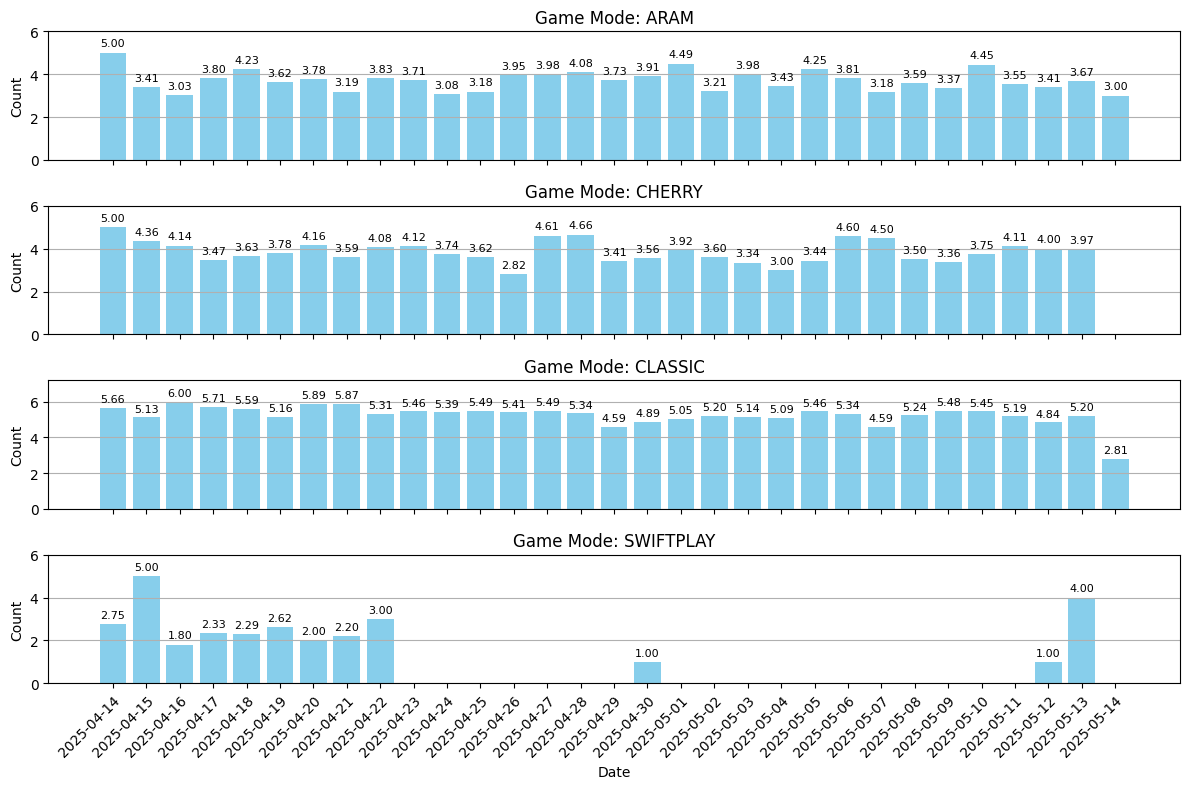

In [185]:
# 1.3 Sessions per User per Day -> 빈도, 활동 습관, 반복성
sessions_per_summoner_per_day = df.groupby(["game_mode", "timestamp"]).summoner_id.nunique().reset_index(name="summoner_count")
sessions_per_summoner_per_day["session_count"] = df.groupby(["game_mode", "timestamp"]).size().reset_index(drop=True)
sessions_per_summoner_per_day["result"] = sessions_per_summoner_per_day["session_count"] / sessions_per_summoner_per_day["summoner_count"]
sessions_per_summoner_per_day

modes = sessions_per_summoner_per_day["game_mode"].unique()
fig, axes = plt.subplots(nrows=len(modes), ncols=1, figsize=(12, 8), sharex=True)

for ax, mode in zip(axes, modes):
    subset = sessions_per_summoner_per_day[sessions_per_summoner_per_day["game_mode"] == mode]
    bars = ax.bar(subset["timestamp"], subset["result"], color="skyblue")
    ax.set_title(f"Game Mode: {mode}")
    ax.set_ylabel("Count")
    ax.grid(axis='y')

    max_height = max([bar.get_height() for bar in bars])
    ax.set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + .2, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=8)

unique_dates = sorted(sessions_per_summoner_per_day.timestamp.unique())
plt.xlabel("Date")
plt.xticks(ticks=unique_dates, rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()

In [157]:
# 1.4 D-d Churn Rate
today = datetime(2025, 5, 14)
cohort_date = today - timedelta(days=30)
cohort_ids = set(df[df.timestamp == cohort_date.date()].summoner_id.unique())

ds = [3, 7, 14, 30]
d_retentions = []
print(f"[INFO] \tTarget Size: {len(cohort_ids)}")
for d in ds:
    cohort_cutoff = cohort_date + timedelta(days=d)
    returned_ids = set(df[
        (df.timestamp > cohort_date.date()) & 
        (df.timestamp <= cohort_cutoff.date())
    ].summoner_id.unique()) & cohort_ids
    
    churned = cohort_ids - returned_ids
    churn_rate = len(churned) / len(cohort_ids)
    print(f"[INFO] \t\tD-{d} Churn Rate is {churn_rate:.4f}")

[INFO] 	Target Size: 220
[INFO] 		D-3 Churn Rate is 0.1091
[INFO] 		D-7 Churn Rate is 0.0364
[INFO] 		D-14 Churn Rate is 0.0182
[INFO] 		D-30 Churn Rate is 0.0045


In [208]:
# 2.1 Access Rate to New Content
target_modes = ["CHERRY", "SWIFTPLAY"]
today = datetime(2025, 5, 14)
ds = [0, 14, 30]
for target_mode in target_modes:
    for d in ds:
        cohort_date = today - timedelta(days=d)
        total_users = set(df[df.timestamp == cohort_date.date()].summoner_id.unique())
        new_content_users = set(df[
            (df.timestamp == cohort_date.date()) &
            (df.game_mode == target_mode)
        ].summoner_id.unique())
        access_rate = len(new_content_users) / len(total_users) if total_users else 0
        print(f"[INFO] {cohort_date.date()}'s Access Rate for New Content '{target_mode}': {access_rate:.4f}")

target_champ = "Mel"
for d in ds:
    cohort_date = today - timedelta(days=d)
    total_users = set(df[df.timestamp == cohort_date.date()].summoner_id.unique())
    new_content_users = set(df[
        (df.timestamp == cohort_date.date()) &
        (df.champion_name == target_champ)
    ].summoner_id.unique())
    access_rate = len(new_content_users) / len(total_users) if total_users else 0
    print(f"[INFO] {cohort_date.date()}'s Access Rate for New Content '{target_champ}': {access_rate:.4f}")


[INFO] 2025-05-14's Access Rate for New Content 'CHERRY': 0.0000
[INFO] 2025-04-30's Access Rate for New Content 'CHERRY': 0.1459
[INFO] 2025-04-14's Access Rate for New Content 'CHERRY': 0.1591
[INFO] 2025-05-14's Access Rate for New Content 'SWIFTPLAY': 0.0000
[INFO] 2025-04-30's Access Rate for New Content 'SWIFTPLAY': 0.0043
[INFO] 2025-04-14's Access Rate for New Content 'SWIFTPLAY': 0.0182
[INFO] 2025-05-14's Access Rate for New Content 'Mel': 0.0625
[INFO] 2025-04-30's Access Rate for New Content 'Mel': 0.0300
[INFO] 2025-04-14's Access Rate for New Content 'Mel': 0.0318


In [210]:
# 2.2 Average/Median Play Count per User
target_modes = ["CHERRY", "SWIFTPLAY"]
for target_mode in target_modes:
    play_counts = df[df.game_mode == target_mode].groupby("summoner_id").size()

    all_users = pd.Series(0, index=df["summoner_id"].unique())
    all_users[play_counts.index] = play_counts

    average_play_count = all_users.mean()
    median_play_count = all_users.median()
    
    print(f"[INFO] Average Play Count per User (30d) for '{target_mode}': {average_play_count:.2f}")
    print(f"[INFO] Median Play Count per User (30d) for '{target_mode}': {median_play_count:.0f}")

target_champ = "Mel"
play_counts = df[df.champion_name == target_champ].groupby("summoner_id").size()

all_users = pd.Series(0, index=df["summoner_id"].unique())
all_users[play_counts.index] = play_counts

average_play_count = all_users.mean()
median_play_count = all_users.median()

print(f"[INFO] Average Play Count per User (30d) for '{target_champ}': {average_play_count:.2f}")
print(f"[INFO] Median Play Count per User (30d) for '{target_champ}': {median_play_count:.0f}")

[INFO] Average Play Count per User (30d) for 'CHERRY': 7.97
[INFO] Median Play Count per User (30d) for 'CHERRY': 0
[INFO] Average Play Count per User (30d) for 'SWIFTPLAY': 0.21
[INFO] Median Play Count per User (30d) for 'SWIFTPLAY': 0
[INFO] Average Play Count per User (30d) for 'Mel': 0.53
[INFO] Median Play Count per User (30d) for 'Mel': 0


In [247]:
# 픽률
x = df[(df.game_mode == 'CLASSIC') & (df.tier == "DIAMOND")]
y = x.champion_name.value_counts() / len(x)
y

champion_name
Lucian    0.031437
Zed       0.030303
Ezreal    0.027108
LeeSin    0.024634
Kaisa     0.024325
            ...   
Zyra      0.000309
Rengar    0.000309
Sona      0.000309
Amumu     0.000309
Ivern     0.000103
Name: count, Length: 168, dtype: float64